<a href="https://colab.research.google.com/github/wangdedi1997/spib/blob/main/examples/tutorial3-trpcage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SPIB Tutorial 3: Trp-cage
This notebook aims to serve as a simple introduction to the state predictive information bottleneck method of [Wang and Tiwary 2021](https://aip.scitation.org/doi/abs/10.1063/5.0038198). The code is implemented using Pytorch.

## Install SPIB using pypi

In [1]:
pip install spib

Looking in indexes: https://test.pypi.org/simple/


## Install packages for Markov modeling

In [2]:
pip install deeptime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.3 MB/s eta 0:00:00


## Download the Trp-cage protein folding trajectory

In [3]:
!gdown 1X-Cf9MIGhWYPpCXcJ2ahKUOr2NcbAozs

Downloading...
From: https://drive.google.com/uc?id=1X-Cf9MIGhWYPpCXcJ2ahKUOr2NcbAozs
To: /content/trpcage_153pairwise_distances_closeheavy_0.2ns_traj.npy
100% 639M/639M [00:08<00:00, 78.9MB/s]


In [1]:
%matplotlib notebook
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import time

plt.rcParams['figure.figsize'] = [25, 20]
np.random.seed(42)

In [2]:
large = 54; med = 36; small = 24
l_width = 3; m_width = 1.5; s_width = 0.7
params = {'axes.titlesize': large,
          'legend.fontsize': large,
          'legend.title_fontsize':large,
          'figure.figsize': (16, 10),
          'axes.labelsize': large,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large,
          'lines.linewidth': l_width,
          'lines.markersize': 10,
          'axes.linewidth': l_width,
          'xtick.major.size': 8,
          'ytick.major.size': 8,
          'xtick.minor.size': 4,
          'ytick.minor.size': 4,
          'xtick.major.width': m_width,
          'ytick.major.width': m_width,
          'xtick.minor.width': s_width,
          'ytick.minor.width': s_width,
          'grid.linewidth': m_width}
plt.rcParams.update(params)

## Data Preparation
The trajectory data can be generated from the molecular dynamics simulation or experiements. Here, we use a sample trajectory generated from Langevin dynamics simulation of a four-well analytical potential.

In [3]:
# Load trajectory data
# time step is 0.2 ns
traj_data = np.load("trpcage_153pairwise_distances_closeheavy_0.2ns_traj.npy")

In [4]:
dt = 0.2

### Visualization of the trajectory

Visualize the trajectory using PCA

In [6]:
from deeptime.decomposition import TICA

## Two hyperparameters to be determined, use GMRQ score to do cross validation
## kinetic_mapping reweigts the eigenvectors by the corresponding eigenvalues, J. Chem. Theory Comput. 2015, 11, 10, 5002–5011
tica = TICA(lagtime=200, dim=3)

tica.fit(traj_data)

model = tica.fetch_model()
tica_projection = model.transform(traj_data)
print(tica_projection.shape)

(1044000, 3)


Text(0, 0.5, '$IC_{1}$')

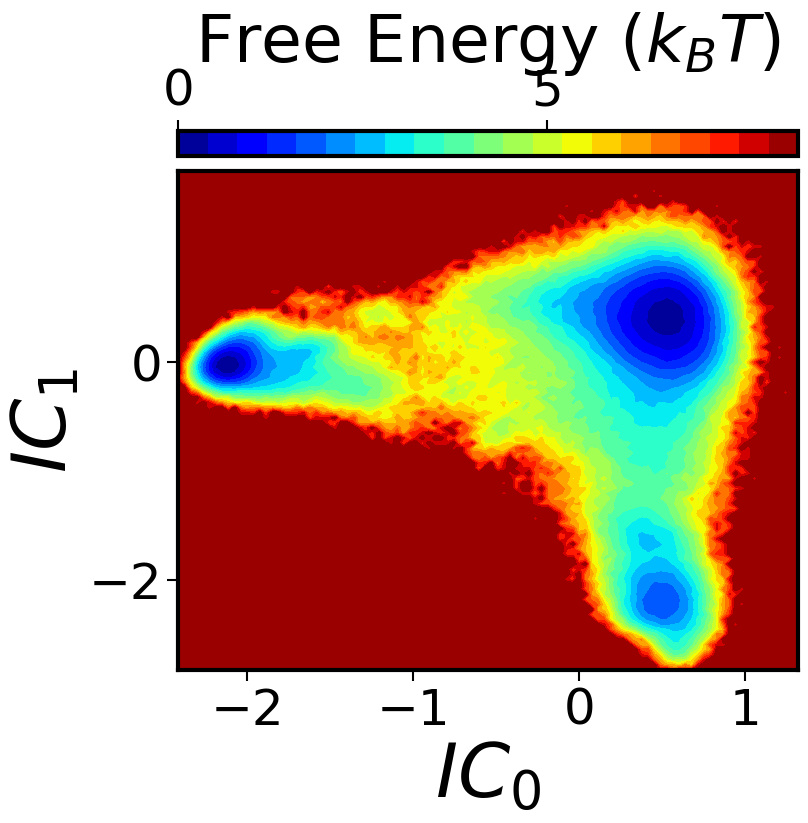

In [7]:
counts, xbins, ybins, images = plt.hist2d(tica_projection[:,0],tica_projection[:,1],bins=100)
counts[counts==0]=counts[counts!=0].min()
G=-np.log(counts)
G=G-np.nanmin(G)

plt.close()

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

h0=plt.contourf(G.transpose(),levels=20,extent=[xbins[0],xbins[-1],ybins[0],ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0, G.max(), 5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"$IC_{0}$")
ax.set_ylabel(r"$IC_{1}$")

Text(0.5, 0, 'time(ns)')

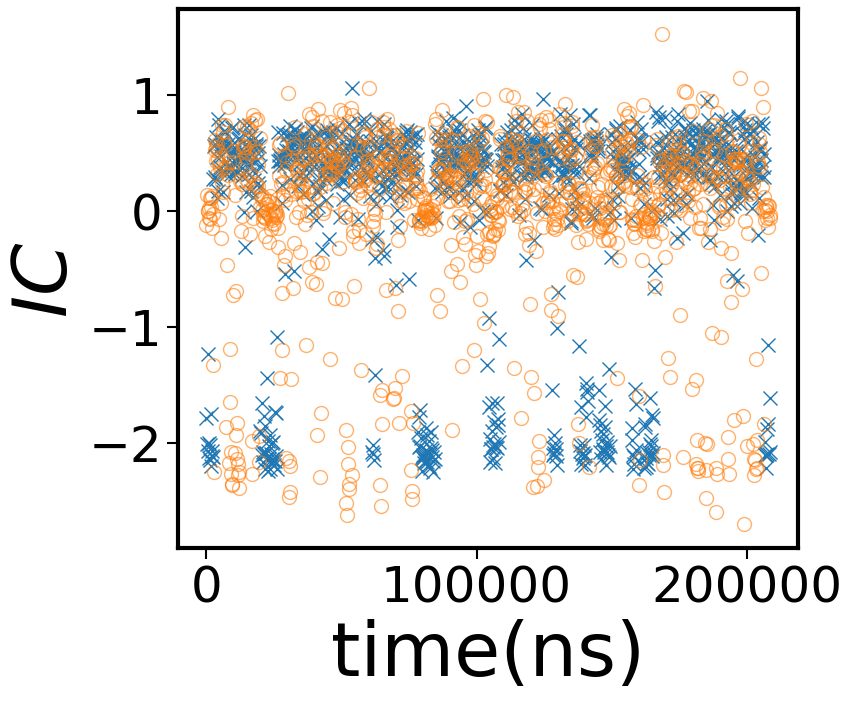

In [8]:
fig,ax = plt.subplots(figsize=(8,7))

plt.plot(np.arange(len(tica_projection))[::1000]*dt, tica_projection[::1000,0], 'x')
plt.plot(np.arange(len(tica_projection))[::1000]*dt, tica_projection[::1000,1], 'o', markerfacecolor='none', alpha=0.6)

ax.set_ylabel(r"$IC$")
ax.set_xlabel(r"time(ns)")

## Model

In [5]:
# import the required packages
import numpy as np
import torch
import os
import torch.nn.functional as F
import random

from spib.spib import SPIB
from spib.utils import prepare_data, DataNormalize

from sklearn.model_selection import KFold
from sklearn.cluster import MiniBatchKMeans

import deeptime.markov as markov
from deeptime.decomposition import TICA

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
default_device = torch.device("cpu")
print(device, default_device)

cuda:0 cpu


In [21]:
# Settings
# ------------------------------------------------------------------------------
# By default, we save all the results in subdirectories of the following path.
base_path = "SPIB"

# Model parameters
# Time delay delta t in terms of # of minimal time resolution of the trajectory data
dt = 500

# Dimension of bottleneck
z_dim = 2

# Encoder type ('Linear' or 'Nonlinear')
encoder_type = 'Nonlinear'

# Number of nodes in each hidden layer of the encoder
neuron_num1 = 64

# Number of nodes in each hidden layer of the encoder
neuron_num2 = 64


# Training parameters
batch_size = 4096

# tolerance of loss change for measuring the convergence of the training
tolerance = 0.002

# Number of epochs with the change of the state population smaller than the threshold after which this iteration of the training finishes
patience = 2

# Minimum refinements
refinements = 15

# Initial learning rate of Adam optimizer
learning_rate = 3e-5

# Hyper-parameter beta
beta = 1e-3

In [22]:
# Random seed
seed = 0

# Set random seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

Generate initial state labels using tICA + kmeans

In [23]:
# Generate initial state labels using tICA + k-means
tica_n_components = 3
tica_lag_time = 200
kmeans_clusters = 200

## get tICA projection
## kinetic_mapping reweigts the eigenvectors by the corresponding eigenvalues, J. Chem. Theory Comput. 2015, 11, 10, 5002–5011
tica = TICA(dim=tica_n_components, lagtime=tica_lag_time)
tica.fit(traj_data)

model = tica.fetch_model()
tica_projection = model.transform(traj_data)

## do clustering on the tICA space as initial labels for SPIB
cluster = MiniBatchKMeans(n_clusters=kmeans_clusters, n_init=5, random_state=seed, batch_size=4096)
cluster.fit(tica_projection)
initial_label = cluster.predict(tica_projection)

In [24]:
# data shape
data_shape = traj_data.shape[1:]
output_dim = np.max(initial_label) + 1

# data normalization
data_transform = DataNormalize(mean=traj_data.mean(axis=0), std=traj_data.std(axis=0))

In [25]:
len(traj_data)

1044000

We now can split data into train and test set

In [26]:
# Evenly divide the ultra-long trajectory
num_div = 100
divtraj = []
divlabel = []
for i in range(num_div):
    if i != num_div - 1:
        divtraj.append(traj_data[int(i * len(traj_data) / num_div):int((i + 1) * len(traj_data) / num_div)])
        divlabel.append(
            initial_label[int(i * len(initial_label) / num_div):int((i + 1) * len(initial_label) / num_div)])
    else:
        divtraj.append(traj_data[int(i * len(traj_data) / num_div):])
        divlabel.append(initial_label[int(i * len(initial_label) / num_div):])

In [27]:
# split data into train and test set
indices = list(range(num_div))
split = int(np.floor(0.1 * num_div))

np.random.shuffle(indices)
train_indices, test_indices = indices[split:], indices[:split]

In order to work with the SPIB it can be convenient to convert the list of trajectory data into a time-lagged dataset.

In [28]:
# prepare the dataset for spib training
train_dataset, test_dataset = prepare_data(divtraj, divlabel, weight_list=None,
                                           output_dim=output_dim, lagtime=dt,
                                           train_indices=train_indices,
                                           test_indices=test_indices, device=device)

In [29]:
# By default, we save all the results in subdirectories of the following path.
IB_path = os.path.join(base_path, "spib")
IB_path

'SPIB\\spib'

Now a SPIB instance can be created. For the full range of possible arguments, please see the API docs.

In [30]:
IB = SPIB(output_dim=output_dim, data_shape=data_shape, encoder_type='Nonlinear', z_dim=z_dim,  lagtime=dt,
          beta=beta, learning_rate=learning_rate, device=device, path=IB_path, UpdateLabel=True,
          neuron_num1=neuron_num1, neuron_num2=neuron_num2, data_transform=data_transform)

Let’s train.

In [31]:
IB.to(device)

IB.fit(train_dataset, test_dataset, batch_size=batch_size, tolerance=tolerance, patience=patience, refinements=refinements, index=seed)

Epoch 1:	Time 1.824126 s
Loss (train) 5.281502	KL loss (train): 0.029594
Reconstruction loss (train) 5.281472
Loss (test) 5.268568	KL loss (test): 0.061245
Reconstruction loss (test) 5.268507
State population:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.16047731 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.17256092 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         

Epoch 4:	Time 11.625424 s
Loss (train) 4.739417	KL loss (train): 1.174055
Reconstruction loss (train) 4.738244
Loss (test) 4.935831	KL loss (test): 1.004375
Reconstruction loss (test) 4.934827
State population:
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.3405991e-02
 1.4978761e-04 0.0000000e+00 4.8827296e-01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.00000

Epoch 7:	Time 21.459528 s
Loss (train) 4.639832	KL loss (train): 1.469836
Reconstruction loss (train) 4.638360
Loss (test) 4.874832	KL loss (test): 1.303833
Reconstruction loss (test) 4.873528
State population:
[0.         0.         0.06373463 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.3976604  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.04045942 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.00696065 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.06003465 0.         0.
 0.         0.07128772 0.         0.         0.         0.
 0.         0.        

Epoch 10:	Time 30.970915 s
Loss (train) 4.558597	KL loss (train): 1.748154
Reconstruction loss (train) 4.556851
Loss (test) 4.814618	KL loss (test): 1.651575
Reconstruction loss (test) 4.812967
State population:
[0.00000000e+00 0.00000000e+00 2.95003336e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.52411121e-01 1.14017435e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 8.28079600e-03 0.00000000e+00 0.00000000e+00
 4.14967574e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000

Epoch 13:	Time 41.034837 s
Loss (train) 4.498725	KL loss (train): 2.033666
Reconstruction loss (train) 4.496692
Loss (test) 4.783276	KL loss (test): 1.927314
Reconstruction loss (test) 4.781348
State population:
[0.0000000e+00 0.0000000e+00 4.6188240e-03 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.2329196e-01
 7.8247258e-06 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1456069e-01 0.0000000e+00 0.0000000e+00 6.1007153e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.2530739e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000

Epoch 16:	Time 50.948455 s
Loss (train) 4.482409	KL loss (train): 2.169710
Reconstruction loss (train) 4.480239
Loss (test) 4.767280	KL loss (test): 2.066304
Reconstruction loss (test) 4.765214
State population:
[0.00000000e+00 0.00000000e+00 2.83702207e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.77834767e-01 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.17645875e-01 0.00000000e+00 0.00000000e+00
 5.52738644e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 5.65727660e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000

Epoch 19:	Time 61.380595 s
Loss (train) 4.470776	KL loss (train): 2.272268
Reconstruction loss (train) 4.468503
Loss (test) 4.754472	KL loss (test): 2.171130
Reconstruction loss (test) 4.752300
State population:
[0.0000000e+00 0.0000000e+00 8.9313654e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.6823943e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1647440e-01 0.0000000e+00 0.0000000e+00 4.6922646e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.6948357e-05 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.8593784e-02 0.0000000e+00 1.6621953e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.3413815e-05 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000

Epoch 22:	Time 71.191491 s
Loss (train) 4.459066	KL loss (train): 2.381421
Reconstruction loss (train) 4.456683
Loss (test) 4.740186	KL loss (test): 2.291632
Reconstruction loss (test) 4.737895
State population:
[0.0000000e+00 0.0000000e+00 9.9374016e-04 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 5.2791190e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1510172e-01 0.0000000e+00 5.0134137e-03 3.5034653e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.1661073e-05 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.9058797e-03 0.0000000e+00 3.6016095e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1469930e-02 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000

Epoch 25:	Time 81.423721 s
Loss (train) 4.445806	KL loss (train): 2.487581
Reconstruction loss (train) 4.443319
Loss (test) 4.726340	KL loss (test): 2.415416
Reconstruction loss (test) 4.723926
State population:
[0.0000000e+00 0.0000000e+00 1.4520455e-03 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 8.8240551e-03
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1285826e-01 0.0000000e+00 2.7263580e-02 1.9611335e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0507489e-04 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 6.2933154e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000

Epoch 28:	Time 90.796110 s
Loss (train) 4.436844	KL loss (train): 2.568497
Reconstruction loss (train) 4.434278
Loss (test) 4.725045	KL loss (test): 2.511291
Reconstruction loss (test) 4.722534
State population:
[0.00000000e+00 0.00000000e+00 1.33802812e-03 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.38520002e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.10205673e-01 0.00000000e+00 1.45092774e-02
 2.90554434e-01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 1.15135255e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.24167231e-05 0.00000000e+00 4.24770842e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.15738874

Epoch 31:	Time 100.635596 s
Loss (train) 4.430975	KL loss (train): 2.642498
Reconstruction loss (train) 4.428334
Loss (test) 4.724307	KL loss (test): 2.589985
Reconstruction loss (test) 4.721716
State population:
[0.0000000e+00 0.0000000e+00 4.7250167e-03 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2964453e-02
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 9.7167447e-02 0.0000000e+00 1.3382517e-02 2.2586854e-01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.2519561e-04 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1111110e-03 0.0000000e+00 1.9192934e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 8.1936056e-03 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.000

Epoch 1:	Time 110.380543 s
Loss (train) 1.455867	KL loss (train): 4.621492
Reconstruction loss (train) 1.451246
Loss (test) 1.603989	KL loss (test): 4.397583
Reconstruction loss (test) 1.599591
State population:
[1.11781801e-05 0.00000000e+00 1.06405094e-01 2.14665774e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.16029510e-03
 1.15135255e-04 0.00000000e+00 1.11781799e-06 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.86830983e-01 6.84009612e-01 0.00000000e+00
 0.00000000e+00]
Relative state population change=0.935803
training loss change=-2.971689
Epoch 2:	Time 112.455306 s
Loss (train) 1.357352	KL loss (train): 4.259754
Reconstruction loss (train) 1.353093
Loss (test) 1.570337	KL loss (test): 4.113095
Reconstruction loss (test) 1.566224
State population:
[6.7069077e-06 0.0000000e+00 1.0662530e-01 2.2123853e-02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 1.2295998e-05 1.3525598e-04 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e

State population:
[0.08836128 0.01833892 0.18975854 0.7035412 ]
Relative state population change=0.004404
training loss change=-0.001223
Epoch 3:	Time 146.212833 s
Loss (train) 0.239493	KL loss (train): 6.865974
Reconstruction loss (train) 0.232627
Loss (test) 0.306610	KL loss (test): 7.280386
Reconstruction loss (test) 0.299329
State population:
[0.08853118 0.0183691  0.18982226 0.7032774 ]
Relative state population change=0.001290
training loss change=-0.000679
Epoch 4:	Time 148.253119 s
Loss (train) 0.238775	KL loss (train): 6.687916
Reconstruction loss (train) 0.232087
Loss (test) 0.307039	KL loss (test): 7.111915
Reconstruction loss (test) 0.299927
State population:
[0.08895484 0.01804382 0.19011289 0.7028884 ]
Relative state population change=0.009208
training loss change=-0.000718
Update 4

Epoch 1:	Time 150.401816 s
Loss (train) 0.229872	KL loss (train): 6.600064
Reconstruction loss (train) 0.223272
Loss (test) 0.291938	KL loss (test): 6.981149
Reconstruction loss (test) 0.2849

State population:
[0.07608987 0.01454952 0.18715402 0.72220653]
Relative state population change=0.002818
training loss change=-0.000635
Update 10

Epoch 1:	Time 199.007298 s
Loss (train) 0.195039	KL loss (train): 5.457445
Reconstruction loss (train) 0.189581
Loss (test) 0.239366	KL loss (test): 5.879374
Reconstruction loss (test) 0.233487
State population:
[0.07698189 0.01450257 0.18711267 0.7214028 ]
Relative state population change=0.006106
training loss change=-0.000238
Epoch 2:	Time 201.167784 s
Loss (train) 0.194490	KL loss (train): 5.391636
Reconstruction loss (train) 0.189098
Loss (test) 0.239219	KL loss (test): 5.862811
Reconstruction loss (test) 0.233356
State population:
[0.07732506 0.014611   0.18716857 0.72089535]
Relative state population change=0.004369
training loss change=-0.000549
Epoch 3:	Time 203.338025 s
Loss (train) 0.194045	KL loss (train): 5.362429
Reconstruction loss (train) 0.188683
Loss (test) 0.238441	KL loss (test): 5.811799
Reconstruction loss (test) 0.232

SPIB(
  (data_transform): DataNormalize()
  (representative_weights): Sequential(
    (0): Linear(in_features=4, out_features=1, bias=False)
    (1): Softmax(dim=0)
  )
  (encoder): Sequential(
    (0): DataNormalize()
    (1): Linear(in_features=153, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
  )
  (encoder_mean): Linear(in_features=64, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
  )
  (decoder_output): Sequential(
    (0): Linear(in_features=64, out_features=4, bias=True)
    (1): LogSoftmax(dim=1)
  )
)

In [32]:
# save torch model
torch.save(IB, IB.output_path + '_final_SPIB%i.model' % seed)

We can visualize the progression of the training:

4


Text(0, 0.5, '# of states')

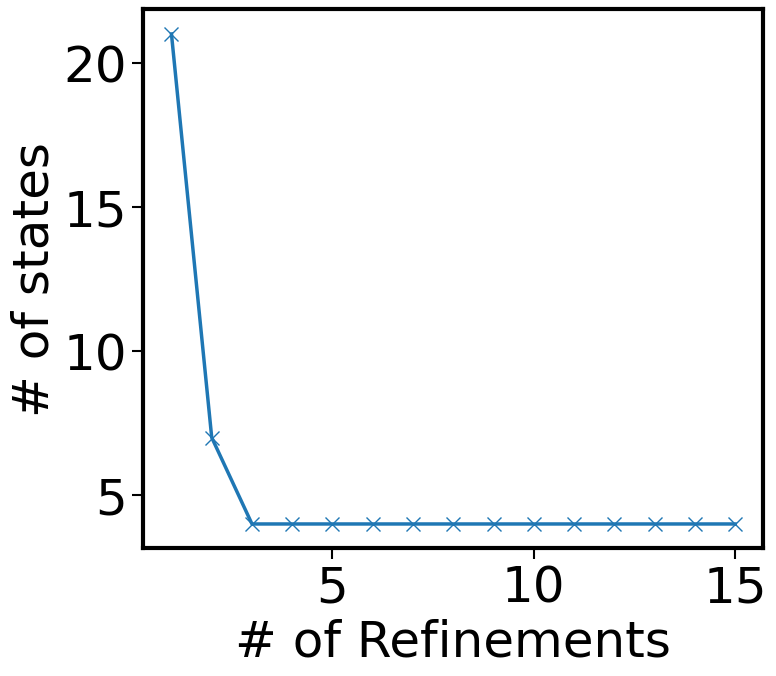

In [33]:
# check the number of SPIB states vs # of Refinements
fig,ax = plt.subplots(figsize=(8,7))

data = np.array(IB.convergence_history)
ax.plot(data[:,0], data[:,2], linestyle='-', linewidth=2.5, marker='x')
print(IB.output_dim)

ax.set_xlabel(r'# of Refinements', fontsize=36)
ax.set_ylabel('# of states', fontsize=36)
#ax.legend(fontsize=24)

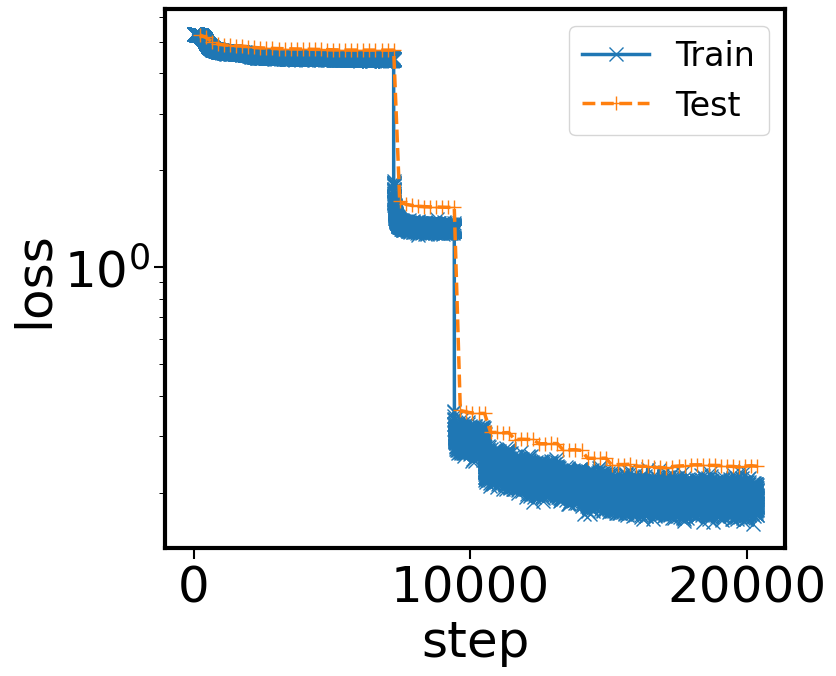

In [34]:
# check loss vs # of Refinements
fig,ax = plt.subplots(figsize=(8,7))

data = np.array(IB.train_loss_history)
ax.plot(data[:,0], data[:,1], linestyle='-', linewidth=2.5, marker='x', label='Train')

data = np.array(IB.test_loss_history)
ax.plot(data[:,0], data[:,1], linestyle='--', linewidth=2.5, marker='+', label='Test')

ax.set_xlabel(r'step', fontsize=36)
ax.set_ylabel('loss', fontsize=36)
ax.set_yscale('log')
ax.legend(fontsize=24)

## Result Analysis

### Qualitative analysis

Transforming and plotting the learned representation and state labels for Trp-cage:

In [35]:
labels, prediction, z_latent, _ = IB.transform(traj_data, batch_size=batch_size, to_numpy=True)

Text(0, 0.5, '$IB_1$')

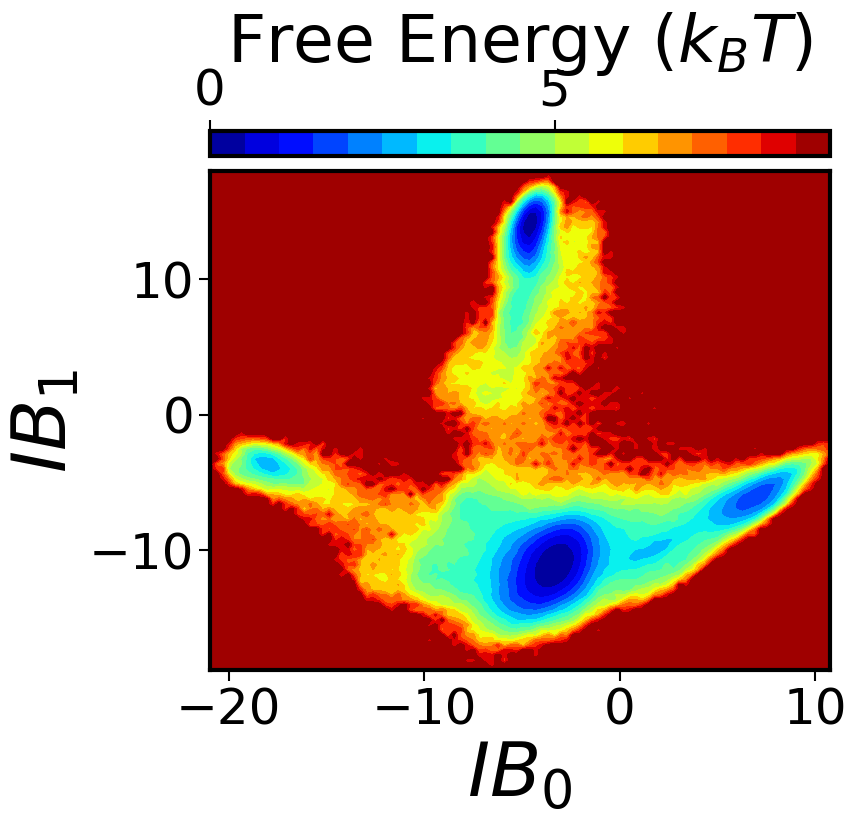

In [36]:
# plot the learned latent reprsentation
RC_counts,RC_xbins,RC_ybins,images = plt.hist2d(z_latent[:,0],z_latent[:,1],bins=100)
RC_counts[RC_counts==0]=RC_counts[RC_counts!=0].min()
RC_G=-np.log(RC_counts)
RC_G=RC_G-np.nanmin(RC_G)

plt.close()

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig,ax = plt.subplots(figsize=(8,7))

lw=8

h0=plt.contourf(RC_G.transpose(),levels=20,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]],cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("top", "5%", pad="3%")
tickz = np.arange(0,RC_G.max(),5)
cb1 = fig.colorbar(h0, cax=cax, orientation="horizontal",ticks=tickz)
cb1.set_label(r'Free Energy ($k_BT$)',fontsize=48)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")
ax.set_xlabel(r"$IB_0$")
ax.set_ylabel(r"$IB_1$")

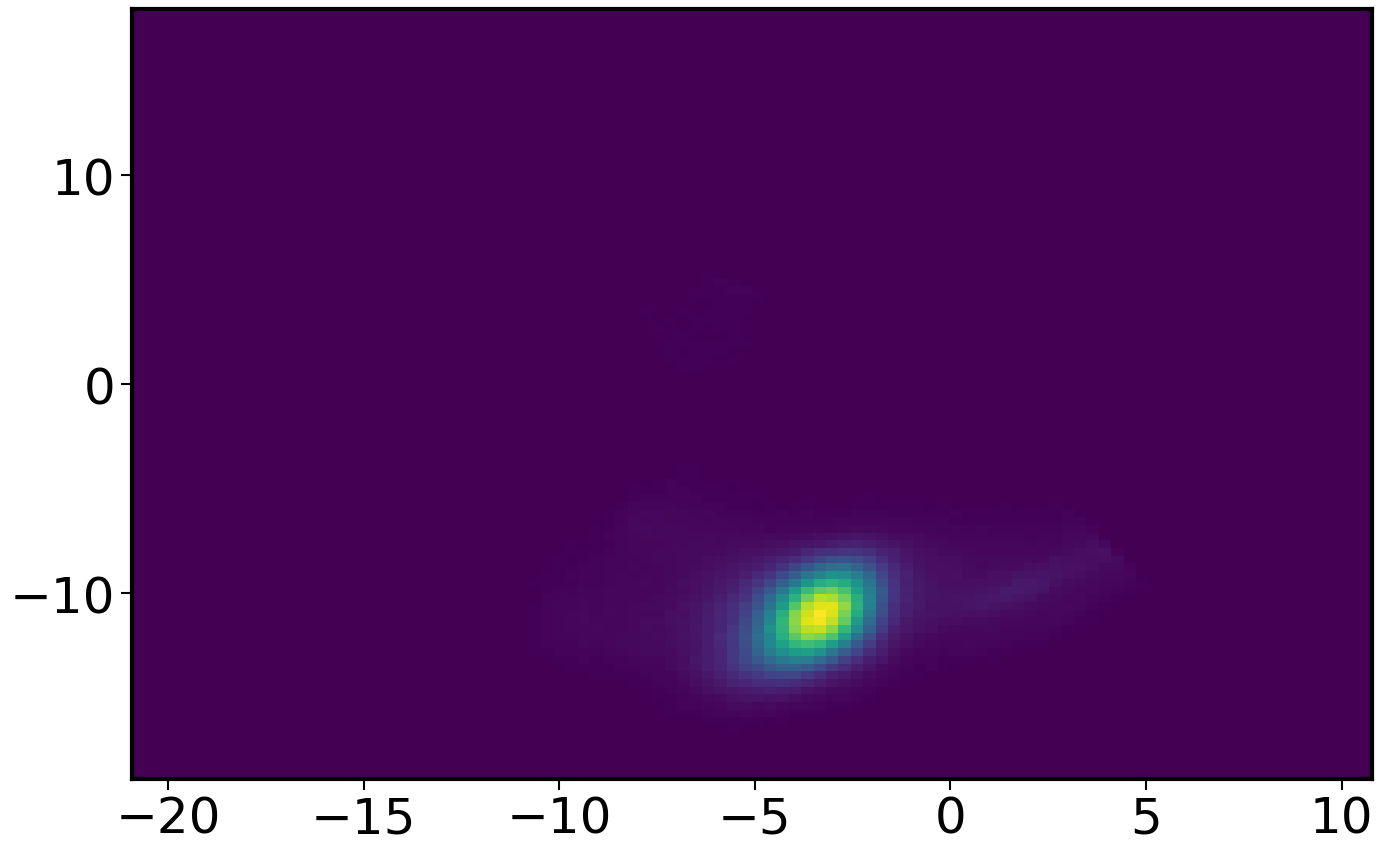

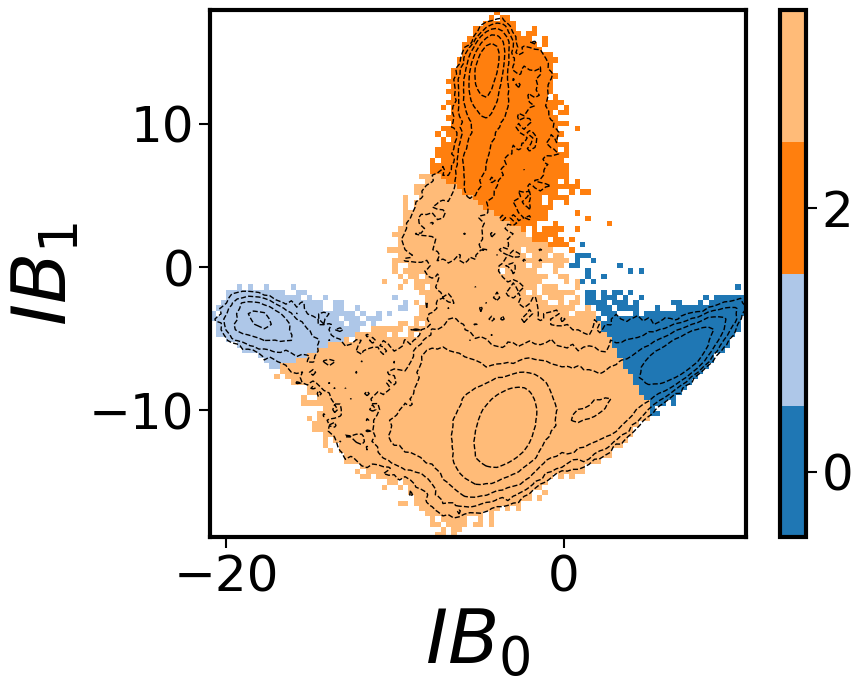

In [37]:
# plot the learned state labels
import matplotlib
from matplotlib import colors as c

data=z_latent
labels=labels
hist=plt.hist2d(data[:,0],data[:,1],bins=100)

state_num=labels.max()+1
state_labels=np.arange(state_num)
hist_state=np.zeros([state_num]+list(hist[0].shape))

for i in range(state_num):
    hist_state[i]=plt.hist2d(data[:,0],data[:,1],bins=[hist[1],hist[2]],weights=(labels==i))[0]
    
label_map=np.argmax(hist_state,axis=0).astype(float)
label_map[hist[0]==0]=np.nan

fig, ax = plt.subplots(figsize=(9,7))

fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: state_labels[x])
tickz = np.arange(0,len(state_labels),2)

cMap = c.ListedColormap(plt.cm.tab20.colors[0:state_num])
im=ax.pcolormesh(hist[1], hist[2], label_map.T, cmap=cMap, vmin=-0.5, vmax=len(state_labels)-0.5)
cb1 = fig.colorbar(im,ax=ax,format=fmt, ticks=tickz)

ax.contour(RC_G.transpose(),levels=5,extent=[RC_xbins[0],RC_xbins[-1],RC_ybins[0],RC_ybins[-1]], colors='black', linewidths=1, linestyles='--')
ax.set_xlabel(r"$IB_0$")
ax.set_ylabel(r"$IB_1$")
plt.tight_layout()
# output the graph
fig = plt.gcf()
#fig.savefig('ion_Full_r_N_label_t=%.1f.png'%(40*0.01))

### Analyze the learned macrostates

In [40]:
# get transformed trajectory
train_SPIB_labels = []
train_SPIB_prediction = []
train_SPIB_z_latent = []
for i in train_indices:
    labels, prediction, z_latent, _ = IB.transform(divtraj[i], batch_size=batch_size, to_numpy=True)
    train_SPIB_labels += [labels]
    train_SPIB_prediction += [prediction]
    train_SPIB_z_latent += [z_latent]

test_SPIB_labels = []
test_SPIB_prediction = []
test_SPIB_z_latent = []
for i in test_indices:
    labels, prediction, z_latent, _ = IB.transform(divtraj[i], batch_size=batch_size, to_numpy=True)
    test_SPIB_labels += [labels]
    test_SPIB_prediction += [prediction]
    test_SPIB_z_latent += [z_latent]

#### (1) GMRQ or VAMP-1 score

Scoring top 3 timescales using MSM with lagtime=100ns 

In [43]:
from deeptime.markov import TransitionCountEstimator

counts = TransitionCountEstimator(lagtime=500, count_mode="sliding").fit(train_SPIB_labels).fetch_model()

msm = markov.msm.MaximumLikelihoodMSM(reversible=True).fit(counts).fetch_model()

n_timescales = 3

if IB.output_dim < n_timescales:
    n_timescales = IB.output_dim

train_SPIB_score = msm.score(train_SPIB_labels, r=1, dim=n_timescales+1)
test_SPIB_score = msm.score(test_SPIB_labels, r=1, dim=n_timescales+1)
print("SPIB train GMRQ: %f"%train_SPIB_score)
print("SPIB validation GMRQ: %f"%test_SPIB_score)

SPIB train GMRQ: 3.546873
SPIB validation GMRQ: 3.114860


#### (2) metastability

In [45]:
from deeptime.markov import TransitionCountEstimator

counts = TransitionCountEstimator(lagtime=500, count_mode="sliding").fit(train_SPIB_labels).fetch_model()

msm = markov.msm.MaximumLikelihoodMSM(reversible=True).fit(counts).fetch_model()

train_SPIB_score = np.diag(msm.transition_matrix).mean()

counts = TransitionCountEstimator(lagtime=500, count_mode="sliding").fit(test_SPIB_labels).fetch_model()

msm = markov.msm.MaximumLikelihoodMSM(reversible=True).fit(counts).fetch_model()

test_SPIB_score = np.diag(msm.transition_matrix).mean()

print("SPIB train metastability: %f"%train_SPIB_score)
print("SPIB validation metastability: %f"%test_SPIB_score)

SPIB train metastability: 0.884677
SPIB validation metastability: 0.795156


#### (3) Shannon's entropy

In [46]:
def calculate_Shannon_entropy(labels):
    state_num = labels.max() + 1
    p = np.array([(labels==i).mean() for i in range(state_num)])
    H = (-p[p != 0.0]*np.log(p[p != 0.0])).sum()
    return H

In [47]:
train_SPIB_score = calculate_Shannon_entropy(np.concatenate(train_SPIB_labels))

test_SPIB_score = calculate_Shannon_entropy(np.concatenate(test_SPIB_labels))

print("SPIB train entropy: %f"%train_SPIB_score)
print("SPIB validation entropy: %f"%test_SPIB_score)

SPIB train entropy: 0.814180
SPIB validation entropy: 0.534584


#### (4) Davies–Bouldin index

In [48]:
from sklearn.metrics import davies_bouldin_score

train_SPIB_score = davies_bouldin_score(np.concatenate([divtraj[i] for i in train_indices],axis=0), np.concatenate(train_SPIB_labels,axis=0))
test_SPIB_score = davies_bouldin_score(np.concatenate([divtraj[i] for i in test_indices],axis=0), np.concatenate(test_SPIB_labels,axis=0))

print("SPIB train DBI: %f"%train_SPIB_score)
print("SPIB validation DBI: %f"%test_SPIB_score)

SPIB train DBI: 1.801642
SPIB validation DBI: 1.861559
